In [4]:
import os
import json
import scipy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model


In [5]:
# Parámetros generales
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
DATASET_PATH = r"C:\Users\Tokyotech\Desktop\weas u\Infra\Trabajo Final\PlantVillage"
MODEL_PATH = "modelo_entrenado.h5"
CLASSES_PATH = "clases.json"

In [6]:
# Función para cargar clases
def cargar_clases(path):
    with open(path, "r") as f:
        class_indices = json.load(f)
    idx_to_class = {v: k for k, v in class_indices.items()}
    return class_indices, idx_to_class

# Función para guardar clases
def guardar_clases(class_indices, path):
    with open(path, "w") as f:
        json.dump(class_indices, f)

In [7]:
# Función para entrenar modelo
def entrenar_modelo():
    print("Entrenando modelo desde cero...")

    # Generadores de datos
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2,
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_gen = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_gen = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    num_classes = len(train_gen.class_indices)

    # Guardar clases
    guardar_clases(train_gen.class_indices, CLASSES_PATH)

    # Modelo base
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True)
    early_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # Entrenamiento
    history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[checkpoint_cb, early_cb])

    # Guardar modelo final
    model.save(MODEL_PATH)
    print("Modelo entrenado y guardado como:", MODEL_PATH)

    # Curva
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Precisión por época")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model 

In [8]:
#  Función para cargar o entrenar modelo
def obtener_modelo():
    if os.path.exists(MODEL_PATH) and os.path.exists(CLASSES_PATH):
        print("Modelo existente encontrado. Cargando...")
        model = load_model(MODEL_PATH)
        class_indices, idx_to_class = cargar_clases(CLASSES_PATH)
    else:
        model = entrenar_modelo()
        class_indices, idx_to_class = cargar_clases(CLASSES_PATH)
    return model, idx_to_class

#  Función de predicción
def predecir_imagen(path_imagen, modelo, idx_to_class):
    img = load_img(path_imagen, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    pred = modelo.predict(img_array)
    clase = idx_to_class[np.argmax(pred)]
    confianza = np.max(pred)
    return clase, confianza

In [9]:
#  EJECUCIÓN PRINCIPAL
modelo, idx_to_class = obtener_modelo()

Modelo existente encontrado. Cargando...


In [10]:
# Ejemplo de predicción
ruta_imagen = r"C:\Users\Tokyotech\Desktop\weas u\Infra\Trabajo Final\PlantVillage\Tests\pepper-bacterial-leaf-spot-close-cropped.jpg"  
clase, prob = predecir_imagen(ruta_imagen, modelo, idx_to_class)
print(f"Predicción: {clase} (confianza: {prob:.2f})")

1/1 [==============================] - 1s 925ms/step
Predicción: Pepper__bell___Bacterial_spot (confianza: 0.72)


In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def mostrar_prediccion(path_imagen, modelo, idx_to_class):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    import numpy as np

    img = load_img(path_imagen, target_size=(224, 224))
    img_array = img_to_array(img)
    img_proc = preprocess_input(np.expand_dims(img_array, axis=0))

    pred = modelo.predict(img_proc)[0]
    clase_pred = idx_to_class[np.argmax(pred)]
    confianza = np.max(pred)

    # Mostrar imagen con texto
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{clase_pred}\nConfianza: {confianza:.2%}", fontsize=14, color="green" if confianza > 0.8 else "orange")
    plt.show()

    # Opcional: barras de clase
    plt.figure(figsize=(8, 4))
    clases = list(idx_to_class.values())
    plt.barh(clases, pred, color='skyblue')
    plt.xlabel("Confianza")
    plt.title("Distribución de probabilidad por clase")
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 35ms/step


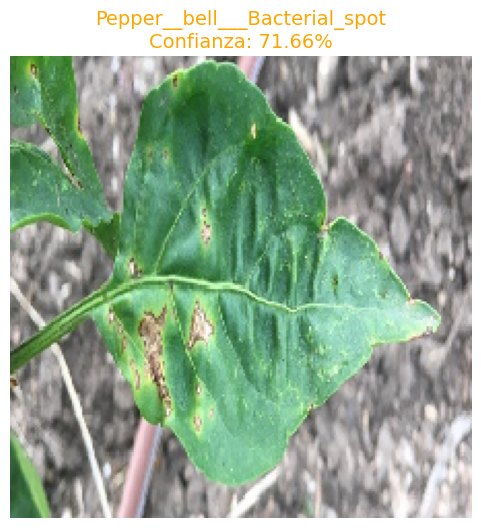

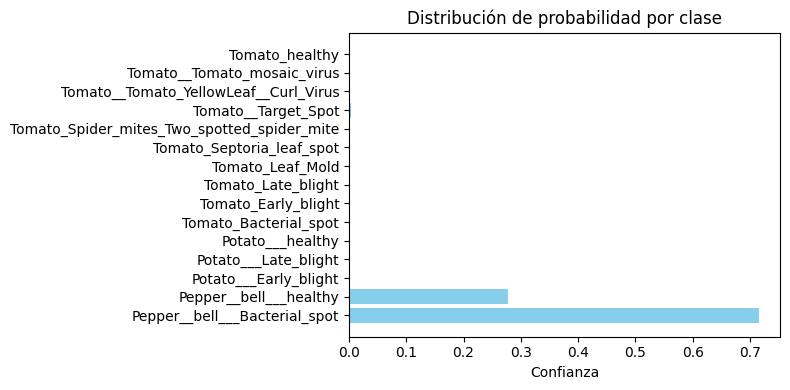

In [12]:
imagen_path = r"C:\Users\Tokyotech\Desktop\weas u\Infra\Trabajo Final\PlantVillage\Tests\pepper-bacterial-leaf-spot-close-cropped.jpg"
mostrar_prediccion(imagen_path, modelo, idx_to_class)

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from glob import glob

# ✅ Tamaño estándar
IMG_SIZE = (128, 128)

# ✅ Cargar imágenes sanas
def cargar_imagenes(directorio, max_imgs=1000):
    rutas = glob(os.path.join(directorio, "*.jpg"))[:max_imgs]
    imagenes = []
    for r in rutas:
        img = load_img(r, target_size=IMG_SIZE)
        img = img_to_array(img) / 255.0
        imagenes.append(img)
    return np.array(imagenes)

# ✅ Entrenamiento del autoencoder
def crear_autoencoder():
    input_img = Input(shape=IMG_SIZE + (3,))
    
    # Codificador
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2))(x)
    
    # Decodificador
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return Model(input_img, decoded)

Epoch 1/20
32/32 [==============================] - 18s 548ms/step - loss: 0.0227
Epoch 2/20
32/32 [==============================] - 16s 513ms/step - loss: 0.0149
Epoch 3/20
32/32 [==============================] - 16s 508ms/step - loss: 0.0123
Epoch 4/20
32/32 [==============================] - 16s 510ms/step - loss: 0.0117
Epoch 5/20
32/32 [==============================] - 16s 510ms/step - loss: 0.0114
Epoch 6/20
32/32 [==============================] - 16s 509ms/step - loss: 0.0110
Epoch 7/20
32/32 [==============================] - 16s 510ms/step - loss: 0.0107
Epoch 8/20
32/32 [==============================] - 16s 506ms/step - loss: 0.0106
Epoch 9/20
32/32 [==============================] - 17s 516ms/step - loss: 0.0105
Epoch 10/20
32/32 [==============================] - 17s 520ms/step - loss: 0.0104
Epoch 11/20
32/32 [==============================] - 16s 505ms/step - loss: 0.0102
Epoch 12/20
32/32 [==============================] - 16s 513ms/step - loss: 0.0100
Epoch 13/20
3

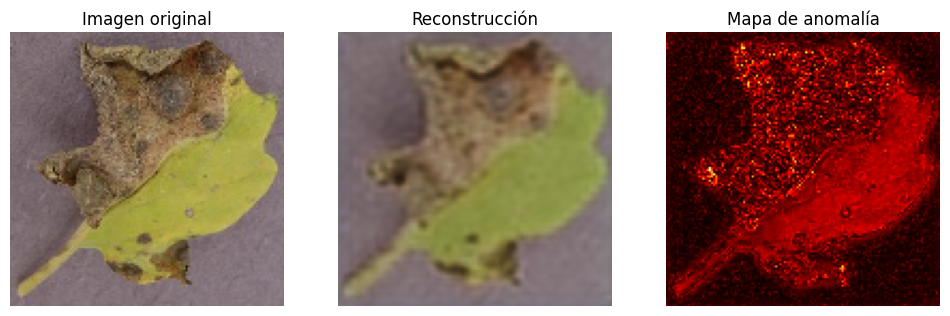

In [16]:
# ✅ Entrenar con imágenes sanas
imagenes_sanas = cargar_imagenes(r"C:\Users\Tokyotech\Desktop\weas u\Infra\Trabajo Final\PlantVillage\Tomato_healthy", max_imgs=1000)
autoencoder = crear_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(imagenes_sanas, imagenes_sanas, epochs=20, batch_size=32, shuffle=True)

# ✅ Visualización de anomalías
def mostrar_anomalia(path_img):
    img = load_img(path_img, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    reconstruida = autoencoder.predict(img_array)
    error = np.abs(img_array[0] - reconstruida[0])
    mapa_error = np.mean(error, axis=-1)

    # Mostrar original vs reconstrucción vs anomalía
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Imagen original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(reconstruida[0])
    plt.title("Reconstrucción")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(mapa_error, cmap="hot")
    plt.title("Mapa de anomalía")
    plt.axis("off")
    plt.show()

# ✅ Prueba con imagen sospechosa
mostrar_anomalia(r"C:\Users\Tokyotech\Desktop\weas u\Infra\Trabajo Final\PlantVillage\Tomato_Septoria_leaf_spot\0c8fd2f4-9c26-4e6d-90b5-fae10602579c___Matt.S_CG 1072.JPG")